<a href="https://colab.research.google.com/github/katherymbr/Dim_fractalMontecarlo_Sierpinskipinsk/blob/main/Blob_1_Con_Metodologia_MIAS_148.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MÉTODOLOGIA PARA SEGMENTACION AUTOMÁTICA DE MICROCALCIFICACIONES Y DETECCIÓN DE BLOBS- MIAS mdb148

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


*    *Microcalcificaciones*







Las microcalcificaciones son depósitos de oxalato cálcico y fosfato cálcico en el tejido mamario que aparecen como manchas blancas en una mamografía. Los mecanismos por los que se producen las microcalcificaciones no se conocen con claridad, aunque se sospecha que intervienen muchos factores, como la edad, los desequilibrios hormonales, el embarazo, la lactancia y los cambios en la dieta (https://www.nature.com/articles/s41598-019-51186-w)

Los depósitos de calcificación se encuentran en el sistema ductal, los acinos mamarios, el estroma y los vasos. Las microcalcificaciones están presentes en aproximadamente el 55% de las neoplasias mamarias no palpables y son responsables de la detección del 85-95% de los casos de carcinoma ductal in situ (CDIS) mediante mamografía , y también pueden estar presentes en cánceres invasivos. El papel de las microcalcificaciones en la detección del cáncer de mama ha sido ampliamente estudiado y algunos grupos de investigación incluso han investigado el papel de las microcalcificaciones en términos de riesgo y progresión del cáncer de mama.

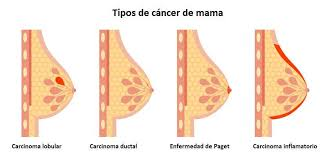

*  Desafios de la segmentación de microcalcificaciones en mamografias:

1.  Tamaño reducido: Las microcalcificaciones generalmente tienen un tamaño que oscila entre Menos de 0.1 mm hasta aproximadamente 1 milímetro de diámetro. Este rango de tamaño puede variar dependiendo de la densidad y composición del tejido mamario.

2. Forma: Pueden ser puntiformes(tiene forma de punto), en forma de líneas o tener una apariencia granular.

3. Distribución: Pueden aparecer solas o en grupos, y la forma en que están distribuidas puede proporcionar pistas importantes sobre su naturaleza benigna o maligna.

4. Superposición de tejidos: Pueden confundirse con tejido cirdundante

*  INFORMACIÓN A TENER EN CUENTA RESPECTO A DISTRIBUCIÓN DE MICROCALCIFICACIONES

Importancia Clínica:

La forma y distribución de las microcalcificaciones puntiformes son importantes para el diagnóstico médico. Las calcificaciones que están dispersas uniformemente suelen ser benignas, mientras que las agrupadas o con patrones específicos pueden ser indicativas de una condición más seria, como el cáncer de mama

*     *Hipotesis*

La población de pixeles en la region de microcalcificacion tiene una distribución donde la media tiene una dimensión fractal más alta que la población de pixeles fuera de la microcalcificación (la población de pixeles que esta en las microcalcificaciones tiene una dimnesión fractal que esta por encima de la dimensión fractal de la media). En terminos de frecuencia, en los puntos donde hay microcalcificaciones hay alta frecuencia.

*     *Dataset*

Base de datos mini-MIAS de mamografías (http://peipa.essex.ac.uk/info/mias.html) .La base de datos mini-MIAS consiste en una colección normalizada de 322 imágenes de mamografías (en blanco y negro), 161 derechas y 161 de izquierda de 1024 × 1024 píxeles.


**1ra columna:**
Número de referencia de la base de datos MIAS.

**2da columna:**
Carácter del tejido de fondo:
  F Graso
  G Graso-glandular
  D densa-glandular

**3ra columna:**
Clase de anormalidad presente:
  CALC Calcificación
  CIRC Masas bien definidas/circunscritas
  SPIC Masas espiculadas
  MISC Otras masas mal definidas
  ARCO Distorsión arquitectónica
  Asimetría ASYM
  NORMA Normal

**4ta columna:**
Gravedad de la anormalidad;
  B Benigno
  M maligno
  
**5ª, 6ª columnas:**
coordenadas de imagen x,y del centro de la anormalidad.
7ma columna:
Radio aproximado (en píxeles) de un círculo que encierra la anomalía.

# FUNCIONES

In [5]:
import imageio as io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from PIL import Image
from skimage import data
from skimage.filters import threshold_multiotsu
import matplotlib
from scipy.stats import linregress
import math
import random
from skimage import io, color, filters, data, exposure

In [6]:
# LEER IMAGEN
def leer_imagen(rute):
  imagen= io.imread(rute)
  return(imagen)

ruta='/content/drive/MyDrive/'

In [7]:
# TAMAÑO DE LA IMAGEN Y EL PIXEL MÁXIMO Y MÍNIMO

def tamaño_imagen(imagen):
    print('dimensiones de la imagen', imagen.shape)
    print ('valor MINIMO del pixel:',imagen.min())
    print('valor MÁXIMO del pixel:', imagen.max())

In [8]:
# GRAFICAR UNA IMAGEN CON TÍTULO

def graficar_imagen(imagen, titulo, tamaño=100):
    fig, ax = plt.subplots(dpi=tamaño)
    ax.imshow(imagen,cmap='gray')
    plt.title(str(titulo))
    plt.show

In [9]:
# GRAFICAR 2 IMAGENES HORIZONTALES CON TÍTULO

import matplotlib.pyplot as plt

def graficar_dosimagenes_horizontaltitulo(imagen_oscura, imagen_brillante, titulo1, titulo2, tamaño=100):
    fig, ax = plt.subplots(1, 2, dpi=tamaño)

    # Primer subgráfico
    ax[0].imshow(imagen_oscura, cmap='gray')
    ax[0].set_axis_off()
    ax[0].set_title(str(titulo1))  # Utilizar set_title para establecer el título

    # Segundo subgráfico
    ax[1].imshow(imagen_brillante, cmap='gray')
    ax[1].set_axis_off()
    ax[1].set_title(str(titulo2))  # Utilizar set_title para establecer el título

    plt.show()


In [10]:
#  GRAFICAR 3 IMAGENES HORIZONTAL + TÍTULO

def graficar_tresimagenes_horizontaltitulo(imagen_oscura, imagen_brillante, imagen1, titulo1, titulo2, titulo3, tamaño=400):
    fig, ax = plt.subplots(1,3, dpi=tamaño)
    ax[0].imshow(imagen_oscura, cmap='gray')
    ax[0].set_axis_off()
    ax[0].set_title(str(titulo1), fontsize=5)
    #plt.title(str(titulo1))
    ax[1].imshow(imagen_brillante, cmap='gray')
    ax[1].set_axis_off()
    ax[1].set_title(str(titulo2), fontsize=5)
    #plt.title(str(titulo2))
    ax[2].imshow(imagen1, cmap='gray')
    ax[2].set_axis_off()
    ax[2].set_title(str(titulo3), fontsize=5)
    plt.show()

In [11]:
#  GRAFICAR 4 IMAGENES HORIZONTAL + TÍTULO

def graficar_cuatroimagenes_horizontaltitulo(imagen1,imagen2,imagen3,imagen4,titulo1,titulo2,titulo3,titulo4):

    # create figure
    fig = plt.figure(figsize=(24, 26))
    # setting values to rows and column variables
    rows = 1
    columns = 4
    # Adds a subplot at the 1st position
    fig.add_subplot(rows, columns, 1)
    # showing image
    plt.imshow(imagen1, cmap="gray")
    plt.axis('off')
    plt.title(str(titulo1))
    # Adds a subplot at the 2nd position
    fig.add_subplot(rows, columns, 2)
    # showing image
    plt.imshow(imagen2, cmap="gray")
    plt.axis('off')
    plt.title(str(titulo2))
    # Adds a subplot at the 3rd position
    fig.add_subplot(rows, columns, 3)
    # showing image
    plt.imshow(imagen3, cmap="gray")
    plt.axis('off')
    plt.title(str(titulo3))
    # Adds a subplot at the 4th position
    fig.add_subplot(rows, columns, 4)
    # showing image
    plt.imshow(imagen4, cmap="gray")
    plt.axis('off')
    plt.title(str(titulo4))

In [12]:
# FUNCIÓN PARA CONSTRUIR LAS FRECUENCIAS DE UN HSITOGRAMA DE LUMINANCIAS

def frecuencias(y1, bins):

    intervalo=np.linspace(0,255, bins+1)
    frecuencia=np.zeros(bins)
    print('frecuencia')
    for i in range(bins):
        #print(intervalo[i], intervalo[i+1])
        frecuencia[i]=((y1>=intervalo[i]) * (y1<intervalo[i+1])). sum()
        #print('frecuencia es', frecuencia[i])
        #print(intervalo[i+1])
    frecuencia[bins-1] += (y1==1).sum()
    return(frecuencia,intervalo)

In [13]:
#funcion para recortar imagenes de Mias

def area_afectada(img5, x,y,r):

    img5_copy=np.copy(img5)
    #cv2.line(imagen264_v2,(x1,y1),(x2,y2),(255,0,0),4)
    cv2.line(img5_copy,(x-r,y-r),(x+r,y-r),(255,0,0),4)
    cv2.line(img5_copy,(x-r,y+r),(x+r,y+r),(255,0,0),4)
    cv2.line(img5_copy,(x-r,y-r),(x-r,y+r),(255,0,0),4)
    cv2.line(img5_copy,(x+r,y-r),(x+r,y+r),(255,0,0),4)
    return(img5_copy)

In [14]:
import matplotlib.pyplot as plt

# Función para graficar 10 imágenes con sus títulos
def graficar_diezimagenes_horizontaltitulo(img1, img2, img3, img4, img5, img6, img7, img8, img9, img10,
                                           t1, t2, t3, t4, t5, t6, t7, t8, t9, t10):
    # Crear figura con DPI especificado
    fig, axes = plt.subplots(2, 5, figsize=(18, 6), dpi=200)
    fig.subplots_adjust(hspace=0.1, wspace=0)  # Ajustar el espacio entre subplots

    # Lista de imágenes y títulos
    imgs = [img1, img2, img3, img4, img5, img6, img7, img8, img9, img10]
    titles = [t1, t2, t3, t4, t5, t6, t7, t8, t9, t10]

    # Iterar sobre las imágenes y títulos para graficar
    for i, (img, title) in enumerate(zip(imgs, titles)):
        ax = axes[i // 5, i % 5]  # Seleccionar el subplot correspondiente
        ax.imshow(img, cmap="gray")
        ax.axis('off')
        ax.set_title(str(title), fontsize=10)  # Ajustar tamaño de título

    # Mostrar la figura
    plt.show()

# Ejemplo de uso
# img1, img2, ... , img10 son tus imágenes
# t1, t2, ... , t10 son tus títulos
# graficar_diezimagenes_horizontaltitulo(img1, img2, img3, img4, img5, img6, img7, img8, img9, img10,
#                                        "Título 1", "Título 2", "Título 3", "Título 4", "Título 5",
#                                        "Título 6", "Título 7", "Título 8", "Título 9", "Título 10")



# funciones de pre_procesamiento

In [15]:
#PASAR LA  IMAGEN AL ESPACIO Y EN GRIS


import numpy as np

def rgb_a_y(matriz_rgb):
    #La función rgb_a_y toma la matriz matriz_rgb que contiene los valores RGB de cada píxel de la imagen
    matriz_rgb = np.array(matriz_rgb) #la matriz RGB se convierte en un arreglo de NumPy utilizando np.array para permitir operaciones vectorizadas.
    coeficientes = np.array([0.299, 0.587, 0.114]) #se define un arreglo coeficientes que contiene los coeficientes de conversión de RGB a Y.
    matriz_y = np.dot(matriz_rgb, coeficientes) #La matriz RGB se multiplica con los coeficientes utilizando np.dot para calcular la suma ponderada de los canales de color. Esto genera una matriz de luminancia matriz_y
    return matriz_y



In [16]:
# FUNCION _TRANSFORMACIÓN LOGARÍTMICA

def transf_log(img):
  img_log= (255/np.log(256))*np.log(img+1.1)

  return(img_log)

In [17]:
# FUNCIÓN DE TRANSFORMACIÓN DE ANSCOMBE

def anscombe(img):
  img_anscombe= 2.0*np.sqrt(img + 3.0/8.0)
  print("Ajustar el rango según el tamaño del pixel max y min de la imágen!!!:")
  tamaño_imagen(img_anscombe)

  return(img_anscombe)


In [18]:
# UMBRALIZACIÓN DE OTSU

import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import threshold_multiotsu

def triple_umbral_otsu(img_log):
    # Setting the font size for all plots.
    plt.rcParams['font.size'] = 9

    # The input image.
    image = img_log

    # Applying multi-Otsu threshold for the default value, generating
    # three classes.
    thresholds = threshold_multiotsu(image)

    # Using the threshold values, we generate the three regions.
    regions = np.digitize(image, bins=thresholds)

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5))

    # Plotting the original image.
    ax[0].imshow(image, cmap='gray',clim=(0, 1))
    ax[0].set_title('Imagen')
    ax[0].axis('off')

    # Plotting the histogram and the two thresholds obtained from
    # multi-Otsu.
    ax[1].hist(image.ravel(), bins=255)
    ax[1].set_title('Histograma')
    for thresh in thresholds:
        ax[1].axvline(thresh, color='r')

    # Plotting the Multi Otsu result.
    ax[2].imshow(regions, cmap='jet')
    ax[2].set_title('Multi-Otsu ')
    ax[2].axis('off')

    plt.subplots_adjust()

    print("El triple umbral de OTSU es (Nota: empieza en 0 - hasta 1) =", thresholds)
    print("El triple umbral de OTSU se visualiza con la paleta JET (0=azul, 1=verde, 2=rojo)")

    plt.show()

    return regions, thresholds


In [19]:
# FUNCIÓN FILTRO DE APERTURA

def filto_apertura(img):
  img_otsu_apertura=img.astype(np.uint8)
  # defino el kernel y su tamaño
  kernel1 = np.ones((2,2),np.uint8)
  #aplico el filtro de apertura y defino las veces que voy a aplicar este filtro (iteraciones)
  opening = cv2.morphologyEx(img_otsu_apertura, cv2.MORPH_OPEN, kernel1)

  return(opening)

In [20]:
# FUNCION DE INTENSIDAD MENDIANTE FUNCIÓN COSENO

def funcion_intesidad_coseno(img):
  img_coseno= 1-np.cos((np.pi/2)*(img/255.0))
  #vmin = 0.0162 # Valor mínimo deseado
 # vmax = 0.0193 # Valor máximo deseado
  print("Ajustar el rango según el tamaño del pixel max y min de la imágen!!!:")
  tamaño_imagen(img_coseno)
  #print("el valor minimo del ranjo ajustado vmax es:", vmax)

  return(img_coseno)


In [21]:
# FUNCIÓN FILTRO DOG (DIFERENCIA DE GAUSS)

import cv2

# FUNCIÓN FILTRO DOG (DIFERENCIA DE GAUSS)
def filtro_dog(img, k1, k2):
    dog_low = cv2.GaussianBlur(img, (3, 3), 0)
    dog_high = cv2.GaussianBlur(img, (5, 5), 0)
    dog = k1 * dog_low - k2 * dog_high
    return dog

In [22]:
# FUNCIÓN PARA CONSTRUIR LAS FRECUENCIAS DE UN HSITOGRAMA DE LUMINANCIAS

def frecuencias(y1, bins):

    intervalo=np.linspace(0,255, bins+1)
    frecuencia=np.zeros(bins)
    print('frecuencia')
    for i in range(bins):
        #print(intervalo[i], intervalo[i+1])
        frecuencia[i]=((y1>=intervalo[i]) * (y1<intervalo[i+1])). sum()
        #print('frecuencia es', frecuencia[i])
        #print(intervalo[i+1])
    frecuencia[bins-1] += (y1==1).sum()
    return(frecuencia,intervalo)

In [23]:
# Función para hacer un histograma.

# la función tuene como parametros de entrada: imagen, nro de bins y el titulo. No tiene retorno porque solo es de visualización

def dibujar_histograma(img, n_bins, title=''):
    h = img.ravel()
    _, nbins = np.histogram(h, bins=n_bins, range=[0, 1])

    plt.hist(h, bins=nbins, edgecolor='black')
    plt.title(format(title))
    #plt.grid()
    plt.show()

In [24]:
# *********************
import cv2

def area_afectada_cuatro_fito(img5, x1, y1, x2, y2, x3, y3, x4, y4):
    img5_copy = np.copy(img5)

    # Color en formato RGB (255, 87, 51) que corresponde a #FF5733
    color = (255, 87, 51)

    # Dibuja las líneas del rectángulo en el color especificado
    cv2.line(img5_copy, (x1, y1), (x2, y2), color, 5)
    cv2.line(img5_copy, (x2, y2), (x3, y3), color, 5)
    cv2.line(img5_copy, (x3, y3), (x4, y4), color, 5)
    cv2.line(img5_copy, (x4, y4), (x1, y1), color, 5)

    return img5_copy

In [25]:
# funcion para CORTAR UNA IMAGEN mamaria en la imagen fito

def imagen_recorte_fito(imagen,y1,y4,x1,x2):
    imagen_recorte= imagen[y1:y4 , x1:x2]
    #graficar_imagen(imagen_recorte , 'imagen recortada', tamaño=90)
    return(imagen_recorte)

In [26]:
# FUNCIÓN ARA HACER 2 HISTOGRAMAS

def hyper_histogram(hyp1, hyp2, n_bins, title1='', title2=''):

    h1 = hyp1[:,:].ravel()
    h2 = hyp2[:,:].ravel()
    _, nbins = np.histogram(h1, bins=n_bins, range=[0, 1])

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].hist(h1, bins=nbins, edgecolor='black')
    axs[0].set_title(format(title1))
    plt.grid()
    axs[1].hist(h2, bins=nbins, edgecolor='black')
    axs[1].set_title(format(title2))
    plt.grid()
    plt.show()

FUNCIONES PARA MIAS

In [27]:
#funcion para dibujar area afectada de Mias
# En esta función el origen de cordenadas está en la esquina inferior izquierda

def dibujar_area_afectada_mias(img, x, y, r):

    # Origen de la imagen en (x=0, y=maximo_y)
    y = img.shape[0] - y
    img_copy = np.copy(img)
    cv2.line(img_copy,(x-r,y-r),(x+r,y-r),(255,0,0),4)
    cv2.line(img_copy,(x-r,y+r),(x+r,y+r),(255,0,0),4)
    cv2.line(img_copy,(x-r,y-r),(x-r,y+r),(255,0,0),4)
    cv2.line(img_copy,(x+r,y-r),(x+r,y+r),(255,0,0),4)
    return img_copy

In [28]:
#funcion para recortar imagenes de Mias
# En esta función el origen de cordenadas está en la esquina inferior izquierda

def recorte_area_afectada_mias(img, x, y, r):
  img_copy = np.copy(img)
  y = img.shape[0] - y
  img_recorte = img_copy[y-r:y+r, x-r:x+r]
  return img_recorte

# FUNCIONES PARA MONTECARLO Y DIM FRACTAL

In [29]:
# FUNCIÓN PARA CALCULAR EL UMBRAL DE OTSU
from skimage import io, color, filters, data, exposure

def Otsu(imagen):

  umbral_otsu= filters.threshold_otsu(imagen)
  # Calcular el histograma de la imagen
  hist, bins_center = exposure.histogram(imagen)

  # Graficar el histograma
  plt.figure(figsize=(10, 5))
  plt.subplot(121)
  plt.bar(bins_center, hist, width=0.5, color='gray')
  plt.title('Histograma de la imagen')
  plt.xlabel('Intensidad de píxel')
  plt.ylabel('Frecuencia')

  # Graficar el umbral de Otsu
  plt.axvline(umbral_otsu, color='r', linestyle='--', linewidth=2, label='Umbral de Otsu')
  plt.legend()

  # Mostrar la imagen original y aplicar el umbral de Otsu
  plt.subplot(122)
  plt.imshow(imagen, cmap='gray')
  plt.title('Imagen con umbral de Otsu')
  plt.axhline(umbral_otsu, color='r',linestyle='--', linewidth=0.01)
  plt.axis('off')
  plt.show()

  return umbral_otsu

In [30]:
# FUNCIÓN PARA BINARIZAR UNA IMAGÉN

def binarizacion(img_norm, umbral):

  im_binary1 = np.copy(img_norm)

  mask_1 = im_binary1 >=  umbral  # umbral_otsu
  mask_2 = im_binary1 <  umbral   # umbral_otsu

  im_binary1[mask_1] = 1 # pixeles mayores, igualeses a umbral_otsu: toman tomar el valor de 1
  im_binary1[mask_2] = 0 # pixeles menores a umbral_otsu: toman tomar el valor de 0

  print(im_binary1.shape)
  print("pixel minimo:",im_binary1.max())
  print("pixel máximo:",im_binary1.min())

  return im_binary1


In [31]:
# FUNCIÓN QUE GENERA EL VIEWPORT CUADRADO A PARTIR DE UNA IMAGEN DE ENTRADA Y UN FACTOR BETA

def viewport_cuadrado(img, beta):
    "beta es el Factor de incremento del viewport con respecto a las dimensiones de la imagen"
    # Definición del área del viewport
    viewport_y, viewport_x = img.shape
    print("--------------------------------------")
    print("Dimensiones de la imagen de entrada a la función - viewport cuadrado-:", img.shape)
    # Ajustar las dimensiones para que el viewport sea cuadrado
    max_dimension = max(viewport_y, viewport_x)
    print("--------------------------------------")
    print("Se tomará el lado mas grande de la imagen de entrada, para formar el cuadrado:", max_dimension)
    # Ajustar las dimensiones dado el factor beta
    max_dimension = int(max_dimension * beta)
    print("--------------------------------------")
    print("El factor de incremento de la iamgen sera un factor Beta: ", beta)
    # Crear un viewport cuadrado
    viewport = np.zeros((max_dimension,  max_dimension))
    print("--------------------------------------")
    print("Dimensiones del viewport: {}".format(viewport.shape))
    print("--------------------------------------")
    return  viewport

# FUNCIÓN PARA DIBUJAR UN CIRCULO ENCIMA DE CUALQUIER IMAGEN DE ENTRADA "cuadrada". Donde el radio del circulo es la mitad del larfo de la imagen

def generar_circulo(img):
    # Obtiene las dimensiones de la imagen
    alto_y, ancho_x = img.shape[:2]
    # Calcula el centro de la imagen
    centro_x = ancho_x / 2
    centro_y = alto_y / 2
    print("++++++++++++++++++++++++++++++++++++++")
    print("El radio del circulo dibujado es:", centro_x)
    print("++++++++++++++++++++++++++++++++++++++")
    # genera el círculo dado el centro
    circulo = plt.Circle((centro_x, centro_y), ancho_x / 2, color='blue', fill=False)
    return circulo

# Función para verificar si un punto cumple con la condición de MONTECARLO
def verificar_condicion(x, y, ancho_x):
    return x ** 2 + y ** 2 <= (ancho_x / 2) ** 2

# FUNCION PARA GENERAR PUNTOS MONTECARLO
def generar_puntos_montecarlo(img, num_puntos):
    print("El total de puntos aleatorios a evaluar es: ", num_puntos)
    print(".....................................")
    puntos_cumplen_condicion = []
    alto_y, ancho_x = img.shape[:2]
    # Definir el número de puntos a generar
    for i in range(num_puntos):
        # Generar coordenadas (x, y) dentro del rango especificado
        x = random.uniform(0, ancho_x)
        y = random.uniform(0, alto_y)

        # Verificar si el punto cumple con la condición
        if verificar_condicion(x - ancho_x / 2, y - alto_y / 2, ancho_x):
            puntos_cumplen_condicion.append((x, y))
    print("los puntos que cumplen la condición de montecarlo sin importar la frontera:",puntos_cumplen_condicion)
    return puntos_cumplen_condicion

#FUNCIÓN PARA VERIFICAR SI LOS 4 PUNTOS DE LA IMAGEN QUE SE INDEXA CUMPLE CON LA CONDICION DE MONTECARLO
# Y NO SE SALEN DEL CIRCULO

def verificar_im_en_circulo(x, y, im, viewport):

    l_view = viewport.shape[0]
    y_im, x_im = im.shape
    x_real = x - l_view/2
    y_real = y - l_view/2
    x_val = None
    y_val = None

    # Verificar que la imagen no se sale del rango del circulo en ninguno de los cuadrantes
    if (verificar_condicion(y_real,        x_real,        l_view) and
        verificar_condicion(y_real + y_im, x_real,        l_view) and
        verificar_condicion(y_real + y_im, x_real + x_im, l_view) and
        verificar_condicion(y_real,        x_real + x_im, l_view)):
      x_val, y_val = x, y
    return x_val, y_val

In [32]:
# **************************** Box counting ***********************************************

# Invoco la función: def box_counting2(img, viewport, x_val, y_val)
# viewport debe ser cuadrado

def box_counting2(img, viewport, x_val, y_val):

    y_im, x_im = img.shape
    viewport[y_val:y_val+y_im, x_val:x_val+x_im] = img

    viewport_y, viewport_x = viewport.shape

    # Obtengo la dimensión mínima del viewport (ahora cuadrado)
    min_axes = min(viewport.shape)

    # Obtener la mayor potencia de 2 que sea menor al valor de min_axes
    nbase = 2 ** np.floor(np.log(min_axes) / np.log(2))

    # Se obtiene el exponente
    n = int(np.log(nbase) / np.log(2))

    #se obtiene el tamaño de los boxes
    # Se obtienen los boxes (media) en base 2^n  hasta 2^1
    boxes = 2 ** np.arange(1, n + 1, 1)[::-1]


    # Contar los pixeles en cada box para cada partición 2^n
    # Considerando el tamaño de los boxes se cuentan los pixeles que hay en cada box, para cada partición 2^n
    counts = []
    for box in boxes:
        bc = np.add.reduceat(
            np.add.reduceat(viewport, np.arange(0, viewport_y, box), axis=0),
            np.arange(0, viewport_x, box), axis=1)
        # Se cuentan el número de box cuya suma de pixels sea mayor a 0 y menor box^2
        counts.append(len(np.where((bc > 0) & (bc < box ** 2))[0]))

    log_inv_boxes_X = np.log(1 / boxes)
    log_counts_y = np.log(counts)
    #print(log_counts_y )


    return log_inv_boxes_X[::-1], log_counts_y[::-1]

# EJECUCIÓN




*     *1. Preprocesamiento*

Para el pre-procesamiento de la imagen se realizarán los pasos desarrollados a continuación:

In [ ]:
# INFORMACIÓN DEL DATASET 'MIAS'

mg_df =pd.read_table('/content/drive/MyDrive/Info.txt', sep=" " )
print('Dataset MIAS')
print('nro, img_MIAS, tejido, anormalidad, gravedad, x, y, c')
print(mg_df)
mg_df.head(100)

Dataset MIAS
nro, img_MIAS, tejido, anormalidad, gravedad, x, y, c
     NO_IMG  T  ANOR    G  XXX  YYY    CCC
0    mdb001  G  CIRC    B  535  425  197.0
1    mdb002  G  CIRC    B  522  280   69.0
2    mdb003  D  NORM  NaN  NaN  NaN    NaN
3    mdb004  D  NORM  NaN  NaN  NaN    NaN
4    mdb005  F  CIRC    B  477  133   30.0
..      ... ..   ...  ...  ...  ...    ...
325  mdb318  D  NORM  NaN  NaN  NaN    NaN
326  mdb319  D  NORM  NaN  NaN  NaN    NaN
327  mdb320  D  NORM  NaN  NaN  NaN    NaN
328  mdb321  D  NORM  NaN  NaN  NaN    NaN
329  mdb322  D  NORM  NaN  NaN  NaN    NaN

[330 rows x 7 columns]


NO_IMG  T  ANOR    G  XXX  YYY    CCC
0   mdb001  G  CIRC    B  535  425  197.0
1   mdb002  G  CIRC    B  522  280   69.0
2   mdb003  D  NORM  NaN  NaN  NaN    NaN
3   mdb004  D  NORM  NaN  NaN  NaN    NaN
4   mdb005  F  CIRC    B  477  133   30.0
..     ... ..   ...  ...  ...  ...    ...
95  mdb095  F  ASYM    M  466  517   29.0
96  mdb096  F  NORM  NaN  NaN  NaN    NaN
97  mdb097  F  ASYM    B  612  297   34.0
98  mdb098  F  NORM  NaN  NaN  NaN    NaN
99  mdb099  D  ASYM    B  714  340   23.0

[100 rows x 7 columns]

In [ ]:
# FILTRO IMAGENES CON ANOMALIAS (ANOR), MICROCALCIFICCAIONES (CALC) MALIGNAS (M)

df_calc = mg_df[mg_df['ANOR'] == 'CALC'] #30 con calcificaciones
df_calc = mg_df[mg_df['G']== 'M']
df_calc.head(100)


NO_IMG  T  ANOR  G    XXX  YYY    CCC
23   mdb023  G  CIRC  M    538  681   29.0
28   mdb028  F  CIRC  M    338  314   56.0
58   mdb058  D  MISC  M    318  359   27.0
72   mdb072  G  ASYM  M    266  517   28.0
75   mdb075  F  ASYM  M    468  717   23.0
90   mdb090  G  ASYM  M    510  547   49.0
92   mdb092  F  ASYM  M    423  662   43.0
95   mdb095  F  ASYM  M    466  517   29.0
102  mdb102  D  ASYM  M    415  460   38.0
105  mdb105  D  ASYM  M    516  279   98.0
110  mdb110  D  ASYM  M    190  427   51.0
111  mdb111  D  ASYM  M    505  575  107.0
115  mdb115  G  ARCH  M    461  532  117.0
117  mdb117  G  ARCH  M    480  576   84.0
120  mdb120  G  ARCH  M    423  262   79.0
124  mdb124  G  ARCH  M    366  620   33.0
125  mdb125  D  ARCH  M    700  552   60.0
130  mdb130  D  ARCH  M    220  552   28.0
135  mdb134  F  MISC  M    469  728   49.0
142  mdb141  F  CIRC  M    470  759   29.0
146  mdb144  F  MISC  M    313  540   27.0
150  mdb148  F  SPIC  M    326  607  174.0
157  mdb155  F  ARCH  M    448  480   95.0
160  mdb158  F  ARCH  M    540  565   88.0
172  mdb170  D  ARCH  M    489  480   82.0
173  mdb171  D  ARCH  M    462  627   62.0
180  mdb178  G  SPIC  M    492  600   70.0
181  mdb179  D  SPIC  M    600  514   67.0
183  mdb181  G  SPIC  M    519  362   54.0
186  mdb184  F  SPIC  M    352  624  114.0
188  mdb186  G  SPIC  M    403  524   47.0
204  mdb202  D  SPIC  M    557  772   37.0
208  mdb206  F  SPIC  M    368  200   17.0
211  mdb209  G  CALC  M    647  503   87.0
213  mdb211  G  CALC  M    680  327   13.0
215  mdb213  G  CALC  M    547  520   45.0
218  mdb216  D  CALC  M  *NOTE   3*    NaN
236  mdb231  F  CALC  M    603  538   44.0
238  mdb233  G  CALC  M  *NOTE   3*    NaN
243  mdb238  F  CALC  M    522  553   17.0
244  mdb239  D  CALC  M    645  755   40.0
245  mdb239  D  CALC  M    567  808   25.0
247  mdb241  D  CALC  M    453  678   38.0
251  mdb245  F  CALC  M  *NOTE   3*    NaN
255  mdb249  D  CALC  M    544  508   48.0
256  mdb249  D  CALC  M    575  639   64.0
260  mdb253  D  CALC  M    733  564   28.0
263  mdb256  F  CALC  M    400  484   37.0
271  mdb264  G  MISC  M    596  431   36.0
272  mdb265  G  MISC  M    593  498   60.0
274  mdb267  F  MISC  M    793  481   56.0
277  mdb270  G  CIRC  M    356  945   72.0
278  mdb271  F  MISC  M    784  270   68.0
281  mdb274  F  MISC  M    127  505  123.0

# **Mamografias**

# **PASO 1. LEO: Imagen mamografia original - MIAS148**

dimensiones de la imagen (1024, 1024)
valor MINIMO del pixel: 0
valor MÁXIMO del pixel: 240


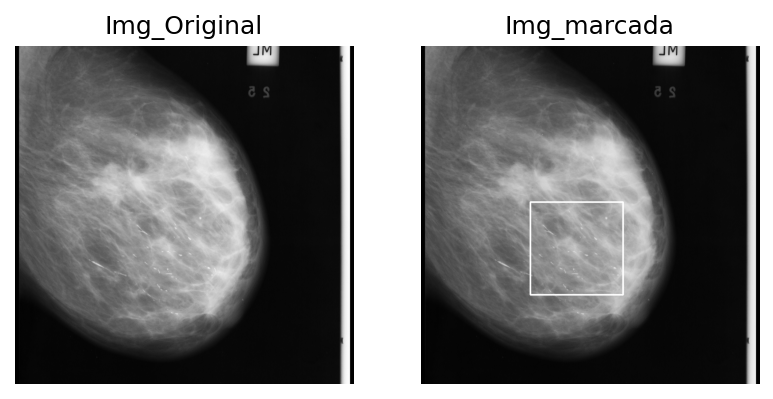

In [33]:
# Leo la imagen de la mamografia Original
# MIAS 148
# SPIC Masas espiculadas


img_original = leer_imagen (ruta+'mdb148.pgm')
tamaño_imagen(img_original)

imagen_marcada = dibujar_area_afectada_mias(img_original,470, 410, 140)  #326, 607, 174 dataset

graficar_dosimagenes_horizontaltitulo(img_original, imagen_marcada,'Img_Original', 'Img_marcada', tamaño=150)

#  Recorto la mamografia

tamaño recorte de la img original: 
dimensiones de la imagen (280, 280)
valor MINIMO del pixel: 94
valor MÁXIMO del pixel: 224
tamaño recorte de la img original después de NORMALIZAR: 


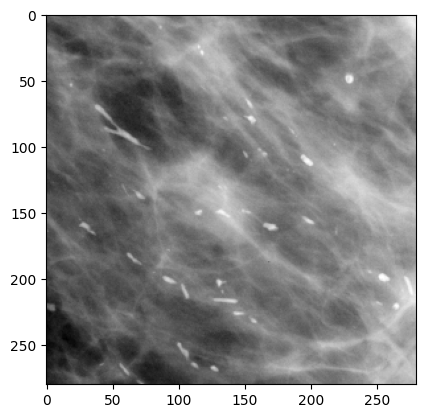

In [34]:
# Invoco una funcion para CORTAR UNA IMAGEN mamaria

imagen_recorte= recorte_area_afectada_mias(img_original, 470, 410, 140 )  # hago el recorte a la imagen original
print("tamaño recorte de la img original: ")
tamaño_imagen(imagen_recorte)

#Normalizo el recorte de la imagen original

imagen_recorte_norm=(imagen_recorte - imagen_recorte.min()) / (imagen_recorte.max() - imagen_recorte.min())  # normalizo la imagen y la llevo a la escala de 0 a 1
print("tamaño recorte de la img original después de NORMALIZAR: ")
plt.imshow(imagen_recorte_norm, cmap='gray')

In [ ]:
cd '/content/drive/MyDrive'

*  Guardo el recorte son bordes blancos y con dimensiones originales
***

dimensiones de la imagen (280, 280)
valor MINIMO del pixel: 0.0
valor MÁXIMO del pixel: 1.0


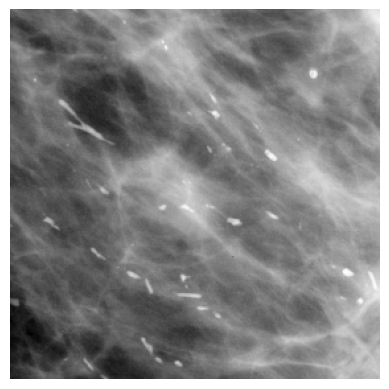

In [35]:
# GUARDO LA IMAGEN: recorte_img209_gris - Guarda la figura sin ejes y bordes

# Guardar imagen---SIN EJES NI BORDES
plt.imsave('recorte_img209_gris-etiqueta5.png', imagen_recorte_norm, cmap='gray')
tamaño_imagen(imagen_recorte_norm)

# Ocultar ejes y bordes solo para la visualización
plt.axis('off')
plt.imshow(imagen_recorte_norm, cmap='gray')

# APLICO METODODLOGIA:

## 1.2. Triple umbral de OTSU:

 la imagen se segmentó en tres clases según el método de umbral múltiple de Otsu. Se mantuvieron las dos clases más luminosas ya que correspondían a la región mamaria y los demás objetos de la mamografía, mientras que la más oscura correspondía al fondo. La mascara de otsu da 3 valores 0=azul, 1=verde,  2=rojo (donde estan las micro)

# 1.2.1 Filtro potencia

Antes de hacerle Otsu al recorte, le aplico un filtro potencia 4, para que me oscureszca la imagen y elimine puntos blancos que pueden ser falsos positivos

In [75]:
factor = 4  # selecciono un filtro de potencia 4

imagen_recorte_norm_potencia= imagen_recorte_norm**factor

"""
# Aplico umbral triple de Otsu a la imagen y filtro potencia factor=4
resultados_segmentacion,umbral_multiOtsu = triple_umbral_otsu(imagen_recorte_norm_potencia)
"""

'\n# Aplico umbral triple de Otsu a la imagen y filtro potencia factor=4\nresultados_segmentacion,umbral_multiOtsu = triple_umbral_otsu(imagen_recorte_norm_potencia)\n'

In [76]:
# Array multiOtsu
"""
print("el umbral MultiOtsu es en el rango de:", umbral_multiOtsu)

umbral_menor, umbral_mayor= umbral_multiOtsu
"""

'\nprint("el umbral MultiOtsu es en el rango de:", umbral_multiOtsu)\n\numbral_menor, umbral_mayor= umbral_multiOtsu\n'

In [77]:
#hyper_histogram(imagen_recorte_norm, imagen_recorte_norm_potencia , 50, title1='Hist.recorte_norm', title2='Hist.recorte_norm_potencia')

In [39]:
# RESULTADO DEL filtro potencia y TRIPLE UMBRAL DE Otsu

#plt.imshow(resultados_segmentacion)

In [78]:
#graficar_tresimagenes_horizontaltitulo(imagen_recorte_norm, imagen_recorte_norm_potencia, resultados_segmentacion,
                                      # 'Img Original','Filtro potencia', ' Multi_Otsu', tamaño=200)

La imagen resultande de la umbralización de Otsu  la binarizo (la pongo en colores negro y blanco). Los valores menores a 2 los haga fondo (negro=0) y los valores 2 quedan blancos(microcalcificaciones)

## 1.2.1. Generacion de la mascara obtenida  en otsu

In [79]:
"""
from typing_extensions import assert_type
import copy

#MASCARA DE OTSU
#plt.imshow(resultados_segmentacion, cmap='gray' )
resultados_segmentacion.shape

# Hago una copia de la imagen  de otsu

resultados_segmentacion_copia1= copy.copy(resultados_segmentacion)

# Aplico el umbral - Modifico el threshold

resultados_segmentacion_copia1[resultados_segmentacion<2 ] = 0  # 2 porq la mascara de otsu da 3 valores 0=azul, 1=verde,  2=rojo (donde estan las micro)
plt.imshow(resultados_segmentacion_copia1, cmap='gray')

# lo normalizo entre 0 y 1 para que me quede en el rango que tiene la mascara segmenteda  manual
resultados_segmentacion_copia1 = resultados_segmentacion_copia1/np.max(resultados_segmentacion_copia1)

#resultados_segmentacion_copia1*=127.5

print("pixel valor minimo",np.min(resultados_segmentacion_copia1))
print("pixel valor maximo",np.max(resultados_segmentacion_copia1))
resultados_segmentacion_copia1.shape
"""

'\nfrom typing_extensions import assert_type\nimport copy\n\n#MASCARA DE OTSU\n#plt.imshow(resultados_segmentacion, cmap=\'gray\' )\nresultados_segmentacion.shape\n\n# Hago una copia de la imagen  de otsu\n\nresultados_segmentacion_copia1= copy.copy(resultados_segmentacion)\n\n# Aplico el umbral - Modifico el threshold\n\nresultados_segmentacion_copia1[resultados_segmentacion<2 ] = 0  # 2 porq la mascara de otsu da 3 valores 0=azul, 1=verde,  2=rojo (donde estan las micro)\nplt.imshow(resultados_segmentacion_copia1, cmap=\'gray\')\n\n# lo normalizo entre 0 y 1 para que me quede en el rango que tiene la mascara segmenteda  manual\nresultados_segmentacion_copia1 = resultados_segmentacion_copia1/np.max(resultados_segmentacion_copia1)\n\n#resultados_segmentacion_copia1*=127.5\n\nprint("pixel valor minimo",np.min(resultados_segmentacion_copia1))\nprint("pixel valor maximo",np.max(resultados_segmentacion_copia1))\nresultados_segmentacion_copia1.shape\n'

## 1.2.3. Filtrado morfologico a la mascara de otsu: por apertura

se le realiza el filtrado de apertura a la mascara obtenida en otsu, en esta mascara solo se ve el seno delimitado

In [80]:
"""
img_apertura= filto_apertura(resultados_segmentacion_copia1)  # con Kernel de 3*3
graficar_imagen(img_apertura , 'f_apertura', tamaño=100)
print('tamaño de la imagen:', img_apertura.shape)
print('pixel máx', np.max(img_apertura))
print('pixel min', np.min(img_apertura))
"""

"\nimg_apertura= filto_apertura(resultados_segmentacion_copia1)  # con Kernel de 3*3\ngraficar_imagen(img_apertura , 'f_apertura', tamaño=100)\nprint('tamaño de la imagen:', img_apertura.shape)\nprint('pixel máx', np.max(img_apertura))\nprint('pixel min', np.min(img_apertura))\n"

In [81]:
#graficar_tresimagenes_horizontaltitulo(resultados_segmentacion,resultados_segmentacion_copia1,img_apertura, 'Multi-Otsu',
                                      # 'Mascara Multi-Otsu','Mascara Multi-Otsu y F_apertura', tamaño=200)

## 1.3. Convolucion entre la mascara de otsu y la imagen original

In [82]:
#PRODUCTO PUNTO ENTRE LA IMAGEN ORIGINAL RECORTADA Y NORMALIZADA * CON LA MASCARA OBTENIDA EN LA BINARIZACIÓN DE OTSU+f. Apertura
"""
producto= imagen_recorte_norm*img_apertura
graficar_imagen(producto , 'producto_punto(img*mask)', tamaño=100)
tamaño_imagen(producto)
"""

"\nproducto= imagen_recorte_norm*img_apertura\ngraficar_imagen(producto , 'producto_punto(img*mask)', tamaño=100)\ntamaño_imagen(producto)\n"

## 2.1.Función de Anscombe

Ajustar el rango según el tamaño del pixel max y min de la imágen!!!:
dimensiones de la imagen (280, 280)
valor MINIMO del pixel: 1.224744871391589
valor MÁXIMO del pixel: 2.345207879911715


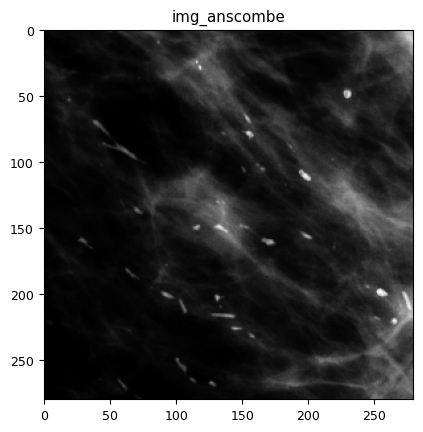

In [68]:
# APLICO LA FUNCIÓN DE ANSCOMBE
img_anscombe= anscombe(imagen_recorte_norm_potencia)
#img_anscombe= anscombe(producto)
graficar_imagen(img_anscombe , 'img_anscombe', tamaño=100)


## 2.2.  transformaciones de intensidad mediante la función coseno

Ajustar el rango según el tamaño del pixel max y min de la imágen!!!:
dimensiones de la imagen (280, 280)
valor MINIMO del pixel: 2.8458931914276953e-05
valor MÁXIMO del pixel: 0.00010434809716375337


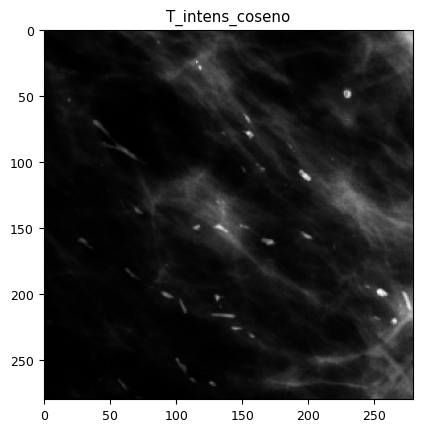

In [69]:
# APLICO LA FUNCION DE TRANSFORMACIÍN DE INTENSIDAD MEDIANTE FUNCIÓN COSENO

img_coseno= funcion_intesidad_coseno(img_anscombe)
graficar_imagen(img_coseno, 'T_intens_coseno', tamaño=100)
#graficar_dosimagenes_horizontaltitulo( img_limpia,img_coseno, "limpia", "coseno", tamaño=100)

## 2.3. Filtro DOG

dimensiones de la imagen (280, 280)
valor MINIMO del pixel: 4.838494146932079e-06
valor MÁXIMO del pixel: 2.542193987944848e-05
******************************************************
tamaño recorte de la img original después de NORMALIZAR: 
dimensiones de la imagen (280, 280)
valor MINIMO del pixel: 0.0
valor MÁXIMO del pixel: 1.0


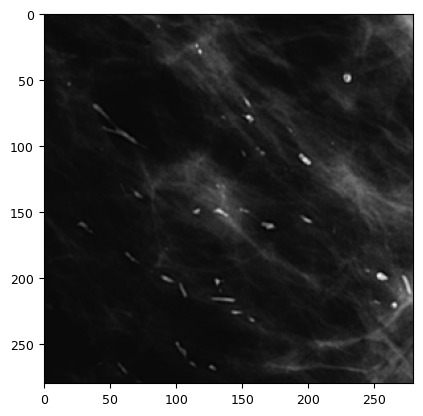

In [70]:
# APLICO EL FILTRO DOG

img_dog1 = filtro_dog(img_coseno, k1=1.1, k2=0.9)
#graficar_imagen(img_dog1, 'F_DOG', tamaño=100)
tamaño_imagen(img_dog1)
#plt.imshow(img_dog1, cmap='gray')
print('******************************************************')
#Normalizo la imagen DOG

img_dog1_norm=(img_dog1 - img_dog1.min()) / (img_dog1.max() - img_dog1.min())  # normalizo la imagen y la llevo a la escala de 0 a 1
print("tamaño recorte de la img original después de NORMALIZAR: ")
tamaño_imagen(img_dog1_norm)
plt.imshow(img_dog1_norm, cmap='gray')

IMAGEN  RESULTANTE, FINAL DE LA METODOLOGÍA

dimensiones de la imagen (280, 280)
valor MINIMO del pixel: 0.0
valor MÁXIMO del pixel: 0.9846153846153847
******************************************************
tamaño recorte de la img original después de NORMALIZAR: 
dimensiones de la imagen (280, 280)
valor MINIMO del pixel: 0.0
valor MÁXIMO del pixel: 1.0


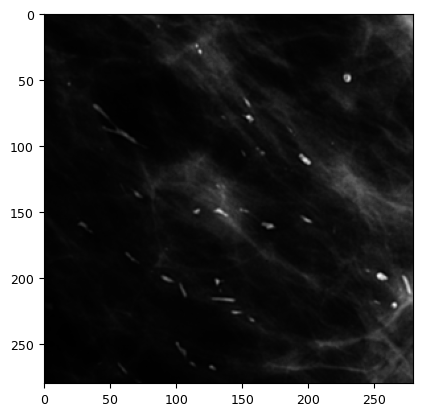

In [71]:
img_final_metodologia= img_dog1_norm*imagen_recorte_norm
tamaño_imagen(img_final_metodologia)
#graficar_imagen(img_final_metodologia, 'Img_final', tamaño=100)

print('******************************************************')
#Normalizo la imagen Final

img_final_metodologia_norm =(img_final_metodologia- img_final_metodologia.min()) / (img_final_metodologia.max() - img_final_metodologia.min())  # normalizo la imagen y la llevo a la escala de 0 a 1
print("tamaño recorte de la img original después de NORMALIZAR: ")
tamaño_imagen(img_final_metodologia_norm)
plt.imshow(img_final_metodologia_norm, cmap='gray')

#  IMAGENES IMPORTANTES EN LA METODOLOGÍA DE SEGMENTACIÓN AUTOMÁTICA

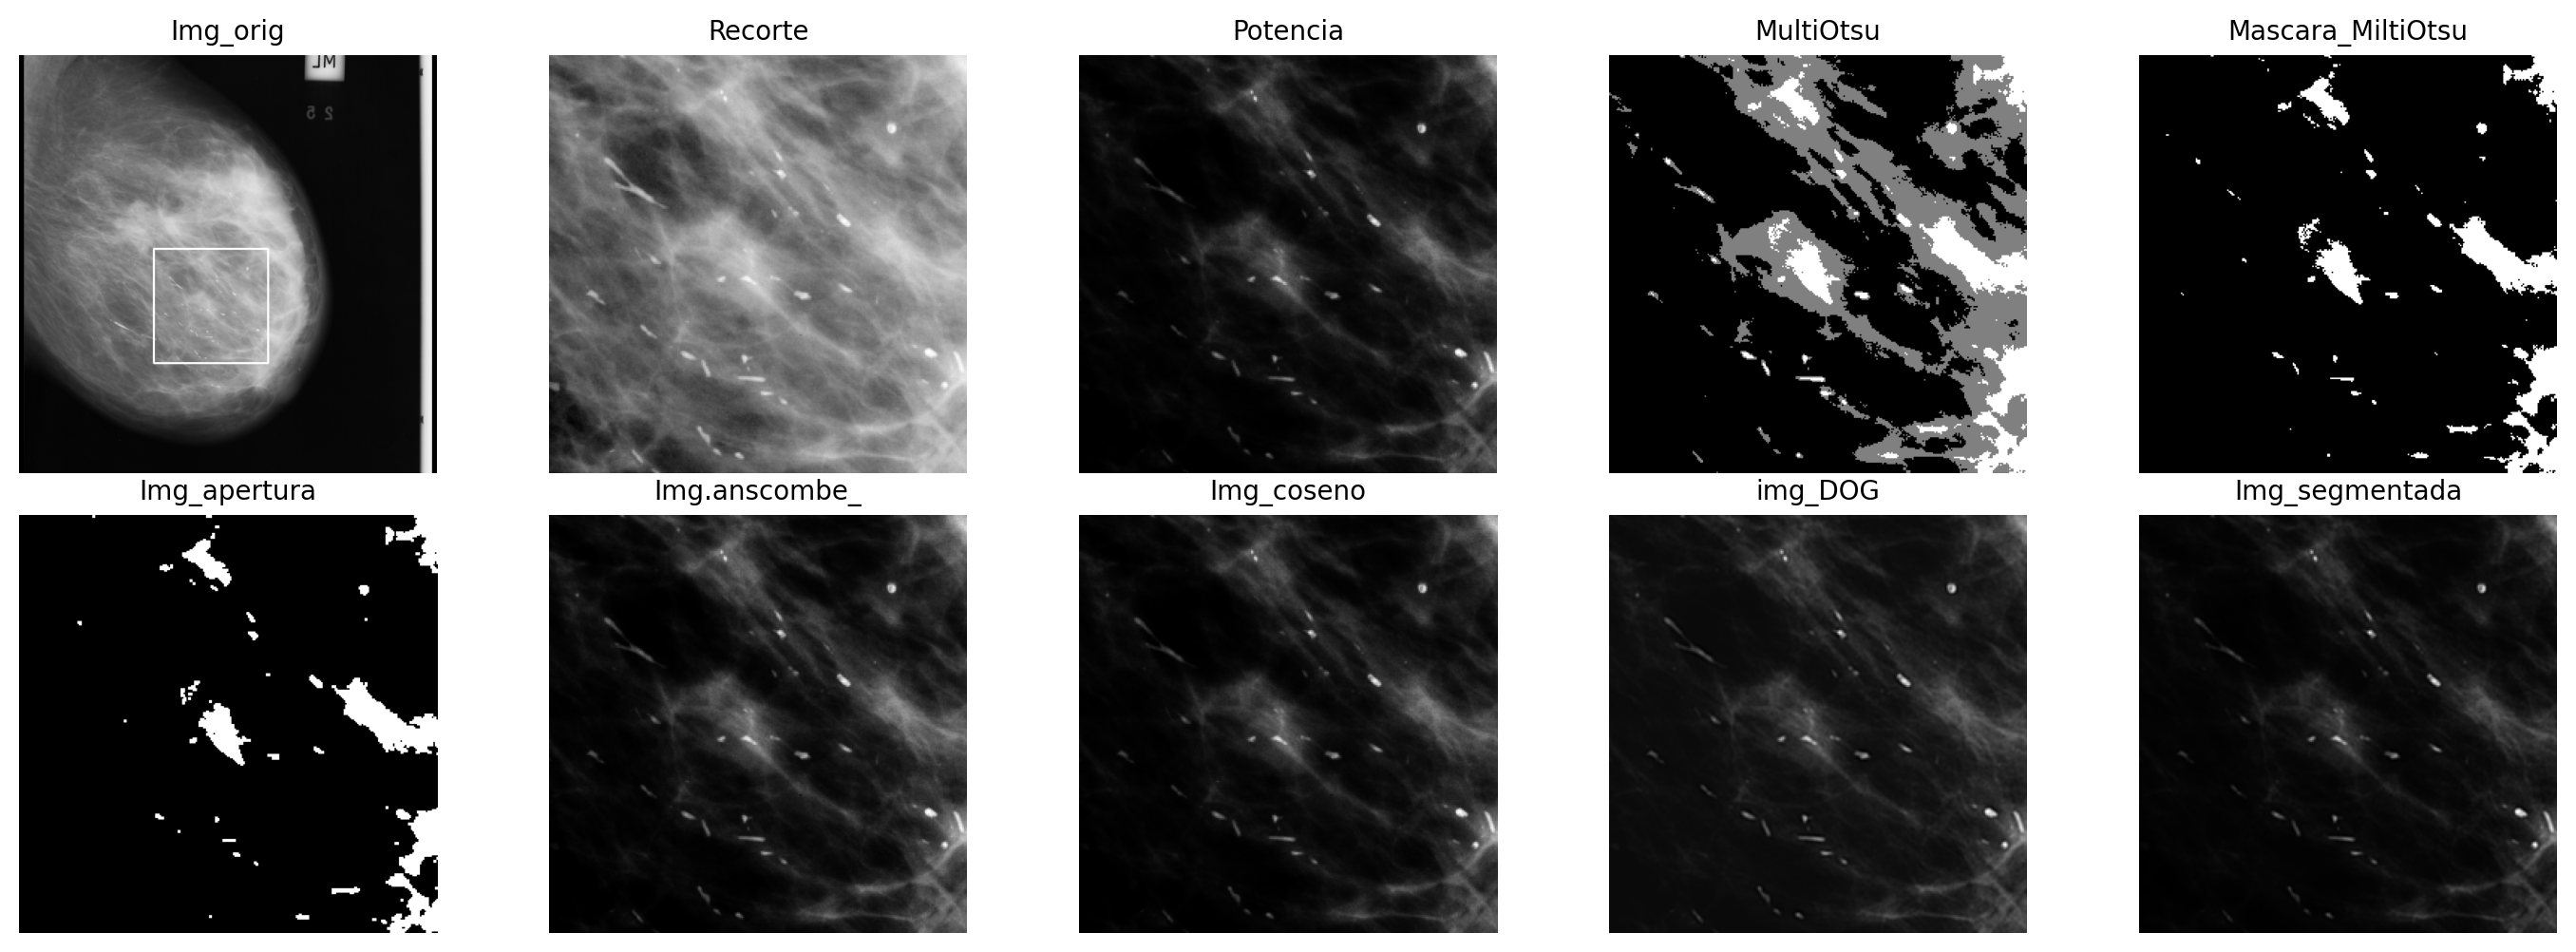

In [72]:
graficar_diezimagenes_horizontaltitulo(imagen_marcada ,imagen_recorte_norm, imagen_recorte_norm_potencia, resultados_segmentacion,
                                       resultados_segmentacion_copia1, img_apertura, img_anscombe, img_coseno,  img_dog1, img_final_metodologia_norm,
                                       'Img_orig','Recorte','Potencia','MultiOtsu','Mascara_MiltiOtsu','Img_apertura','Img.anscombe_',
                                       'Img_coseno','img_DOG','Img_segmentada')

# BLOBS

suguerencia de fuente: https://zhuanlan.zhihu.com/p/138341025

Parametros: max_sigma = 10

el blob es: 0
el blob es: 1
el blob es: 2


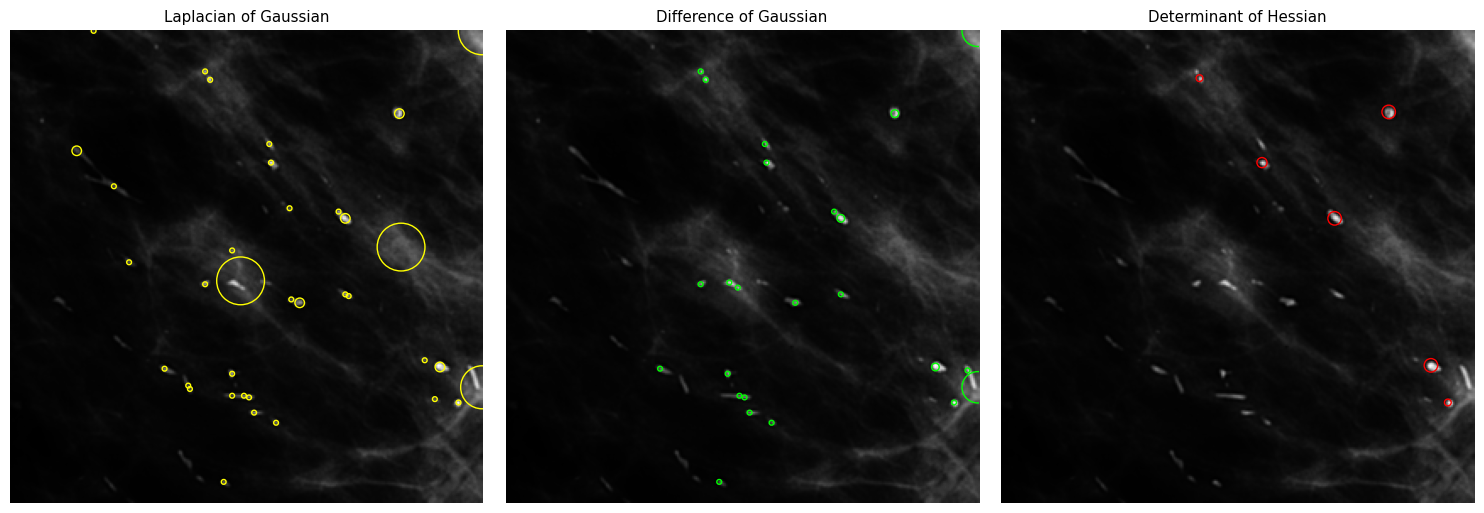

Parametros: max_sigma = 20

el blob es: 0
el blob es: 1
el blob es: 2


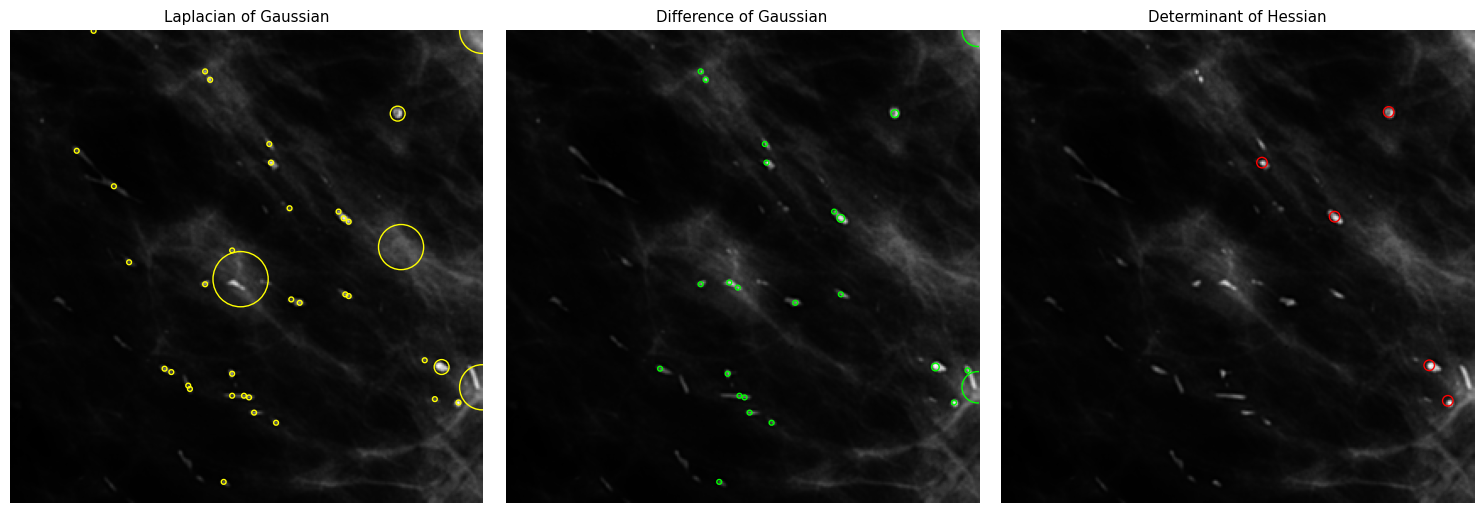

Max_sigma = 10
Detector: Laplacian of Gaussian
Radio Mínimo: 1.4142135623730951
Radio Máximo: 14.142135623730951
Radio Promedio: 2.985561965009867
Desviación Estándar de r: 0.0
Media de r: 2.985561965009867
Detector: Difference of Gaussian
Radio Mínimo: 1.4142135623730951
Radio Máximo: 9.268190002368318
Radio Promedio: 2.174777616217346
Desviación Estándar de r: 0.0
Media de r: 2.174777616217346
Detector: Determinant of Hessian
Radio Mínimo: 2.0
Radio Máximo: 4.0
Radio Promedio: 3.1666666666666665
Desviación Estándar de r: 0.0
Media de r: 3.1666666666666665
Max_sigma = 20
Detector: Laplacian of Gaussian
Radio Mínimo: 1.4142135623730951
Radio Máximo: 16.342023387422433
Radio Promedio: 2.906994544878028
Desviación Estándar de r: 0.0
Media de r: 2.906994544878028
Detector: Difference of Gaussian
Radio Mínimo: 1.4142135623730951
Radio Máximo: 9.268190002368318
Radio Promedio: 2.174777616217346
Desviación Estándar de r: 0.0
Media de r: 2.174777616217346
Detector: Determinant of Hessian
Radi

In [84]:

# MIN-sigma son filtro y con datos estadisticos

from math import sqrt
from skimage import data
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray
import numpy as np


max_sigma=[10,20 ]



# Listas para almacenar los valores
min_radios = []
max_radios = []
promedio_radios = []
desviaciones = []
medias = []

for j in max_sigma:
    blobs_log = blob_log(img_final_metodologia_norm, min_sigma=1,max_sigma=j, threshold=0.1)
    blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

    blobs_dog = blob_dog(img_final_metodologia_norm, min_sigma=1, max_sigma=j,threshold=0.1)
    blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)

    blobs_doh = blob_doh(img_final_metodologia_norm, min_sigma=1,max_sigma=j, threshold=0.01)

    print("Parametros: max_sigma =", j)

    # Listas para almacenar los valores en este valor de min_sigma
    min_radios_sigma = []
    max_radios_sigma = []
    promedio_radios_sigma = []
    desviaciones_sigma = []
    medias_sigma = []

    for blobs in [blobs_log, blobs_dog, blobs_doh]:
        radios_sigma = []
        for blob in blobs:
            y, x, r = blob
            radios_sigma.append(r)

        min_radios_sigma.append(min(radios_sigma))
        max_radios_sigma.append(max(radios_sigma))
        promedio_radios_sigma.append(np.mean(radios_sigma))
        desviaciones_sigma.append(np.std(radios_sigma))
        medias_sigma.append(np.mean(radios_sigma))

    min_radios.append(min_radios_sigma)
    max_radios.append(max_radios_sigma)
    promedio_radios.append(promedio_radios_sigma)
    desviaciones.append(desviaciones_sigma)
    medias.append(medias_sigma)

    blobs_list = [blobs_log, blobs_dog, blobs_doh]
    colors = ['yellow', 'lime', 'red']
    titles = ['Laplacian of Gaussian', 'Difference of Gaussian', 'Determinant of Hessian']

    sequence = zip(blobs_list, colors, titles)
    print()

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    ax = axes.ravel()

    for idx, (blobs, color, title) in enumerate(sequence):
        print("el blob es:", idx)
        axes[idx].set_title(title)
        axes[idx].imshow(img_final_metodologia_norm, cmap="gray")
        for blob in blobs:
            y, x, r = blob
            c = plt.Circle((x, y), r, color=color, linewidth=1, fill=False)
            ax[idx].add_patch(c)
        ax[idx].set_axis_off()

    plt.tight_layout()
    plt.show()

# Mostrar los valores al final
for i, j in zip(max_sigma, range(len(min_radios))):
    print(f"Max_sigma = {i}")
    for k, title in zip(range(len(min_radios[j])), titles):
        print(f"Detector: {title}")
        print(f"Radio Mínimo: {min_radios[j][k]}")
        print(f"Radio Máximo: {max_radios[j][k]}")
        print(f"Radio Promedio: {promedio_radios[j][k]}")
        print(f"Desviación Estándar de r: {np.std(desviaciones[j][k])}")
        print(f"Media de r: {np.mean(medias[j][k])}")

* Blobs img final de la metodologia

Parametros: max_sigma. FILTRO BLOBS_DOG. Diference of Gaussian
10
el blob es: 0
el blob es: 1
el blob es: 2


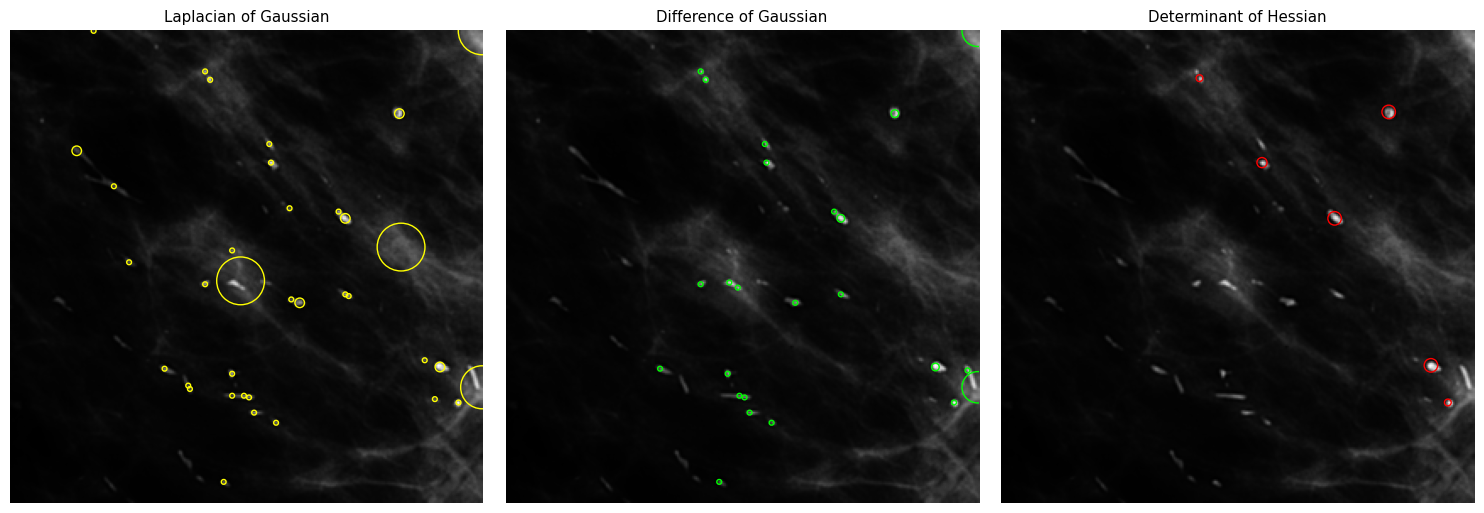

Parametros: max_sigma. FILTRO BLOBS_DOG. Diference of Gaussian
20
el blob es: 0
el blob es: 1
el blob es: 2


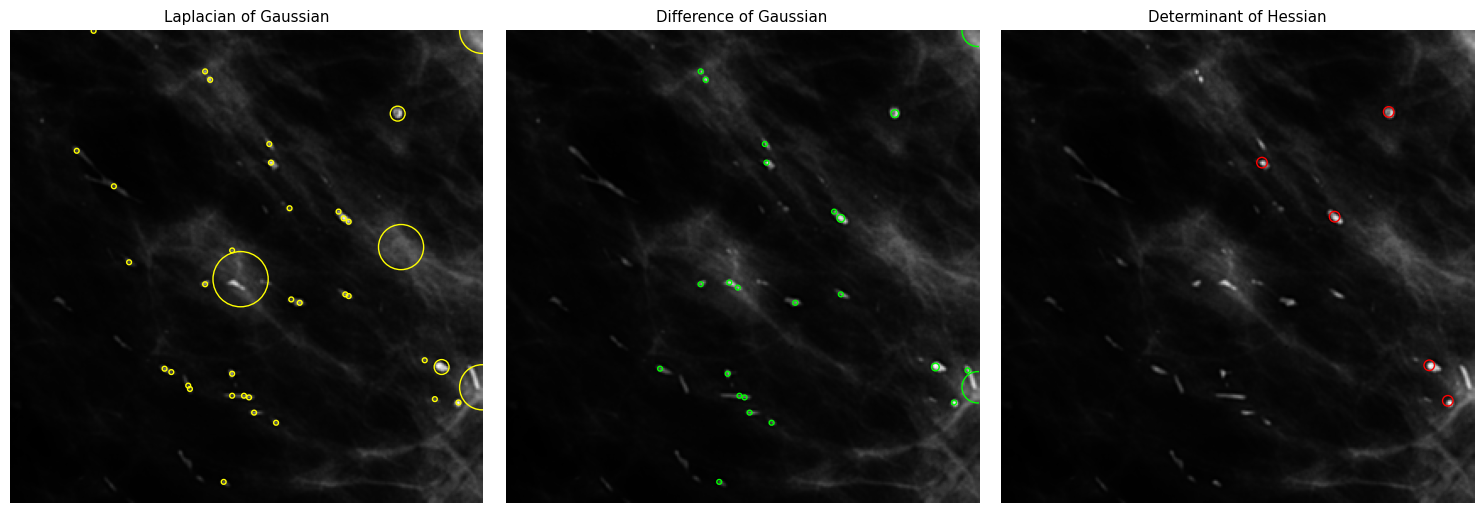

Max_sigma = 10
Blobs encontrados por blobs_dog: 24
Max_sigma = 20
Blobs encontrados por blobs_dog: 24


In [74]:

from math import sqrt
from skimage import data
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray

import matplotlib.pyplot as plt


max_sigma=[10,20]


for k in max_sigma:
    blobs_log = blob_log(img_final_metodologia_norm, min_sigma=1,max_sigma=k, threshold=0.1)
    # Compute radii in the 3rd column.
    print("Parametros: max_sigma. FILTRO BLOBS_DOG. Diference of Gaussian")
    blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

    blobs_dog = blob_dog(img_final_metodologia_norm, min_sigma=1,max_sigma=k,threshold=.1)
    blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)

    blobs_doh = blob_doh(img_final_metodologia_norm, min_sigma=1, max_sigma=k,threshold=0.01)

    blobs_list = [blobs_log, blobs_dog, blobs_doh]
    colors = ['yellow', 'lime', 'red']
    titles = ['Laplacian of Gaussian', 'Difference of Gaussian',
              'Determinant of Hessian']
    sequence = zip(blobs_list, colors, titles)
    print(k)

    #fig,axes = plt.subplots(1,2, figsize=(15, 3), sharex=True, sharey=True)
    #ax = axes.ravel()

    fig, axes = plt.subplots( 1,3,figsize=(15, 5))
    ax = axes.ravel()

    for idx, (blobs, color, title) in enumerate(sequence):
        print("el blob es:", idx)
        axes[idx].set_title(title)
        axes[idx].imshow(img_final_metodologia_norm, cmap="gray")
        for blob in blobs:
            y, x, r = blob
            #print("el radio es:", r)
            c = plt.Circle((x, y), r, color=color, linewidth=1, fill=False)
            ax[idx].add_patch(c)
        ax[idx].set_axis_off()

    #graficar_imagen(recorte_209_rgb, 'img_rgb', tamaño=60)

    plt.tight_layout()
    plt.show()

##############
for k1 in max_sigma:
   # blobs_log = blob_log(imagen_final_norm, min_sigma=1, max_sigma=k1,threshold=0.1)
    blobs_dog = blob_dog(img_final_metodologia_norm, min_sigma=1, max_sigma=k1,threshold=0.1)
   # blobs_doh = blob_doh(imagen_final_norm,min_sigma=1, max_sigma=k1, threshold=0.01)

    print(f"Max_sigma = {k1}")
   # print(f"Blobs encontrados por blobs_log: {len(blobs_log)}")
    print(f"Blobs encontrados por blobs_dog: {len(blobs_dog)}")
    #print(f"Blobs encontrados por blobs_doh: {len(blobs_doh)}")


*  Blobs img filtro potencia de la metodologia - usar la metodologia hasta este filtro

Parametros: max_sigma. FILTRO BLOBS_DOG. Diference of Gaussian
10
el blob es: 0
el blob es: 1
el blob es: 2


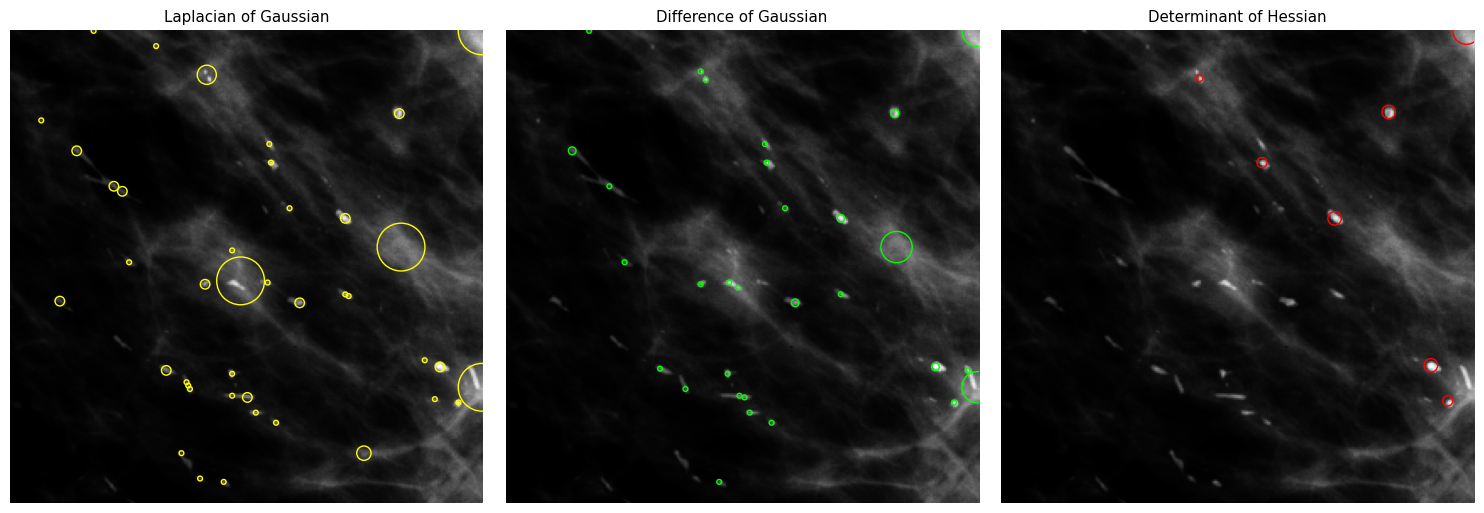

Parametros: max_sigma. FILTRO BLOBS_DOG. Diference of Gaussian
20
el blob es: 0
el blob es: 1
el blob es: 2


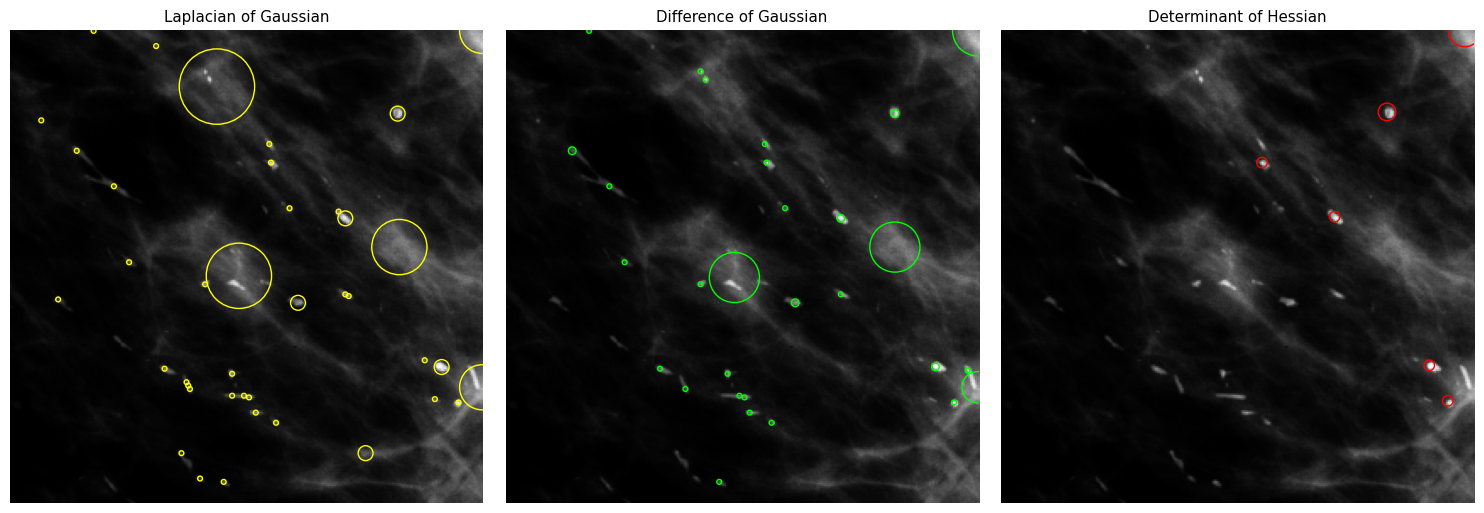

Max_sigma = 10
Blobs encontrados por blobs_dog: 30
Max_sigma = 20
Blobs encontrados por blobs_dog: 29


In [64]:

from math import sqrt
from skimage import data
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray

import matplotlib.pyplot as plt

max_sigma=[10,20]


for k in max_sigma:
    blobs_log = blob_log(imagen_recorte_norm_potencia, min_sigma=1,max_sigma=k, threshold=0.1)
    # Compute radii in the 3rd column.
    print("Parametros: max_sigma. FILTRO BLOBS_DOG. Diference of Gaussian")
    blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

    blobs_dog = blob_dog(imagen_recorte_norm_potencia, min_sigma=1,max_sigma=k,threshold=.1)
    blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)

    blobs_doh = blob_doh(imagen_recorte_norm_potencia, min_sigma=1, max_sigma=k,threshold=0.01)

    blobs_list = [blobs_log, blobs_dog, blobs_doh]
    colors = ['yellow', 'lime', 'red']
    titles = ['Laplacian of Gaussian', 'Difference of Gaussian',
              'Determinant of Hessian']
    sequence = zip(blobs_list, colors, titles)
    print(k)

    #fig,axes = plt.subplots(1,2, figsize=(15, 3), sharex=True, sharey=True)
    #ax = axes.ravel()

    fig, axes = plt.subplots( 1,3,figsize=(15, 5))
    ax = axes.ravel()

    for idx, (blobs, color, title) in enumerate(sequence):
        print("el blob es:", idx)
        axes[idx].set_title(title)
        axes[idx].imshow(imagen_recorte_norm_potencia, cmap="gray")
        for blob in blobs:
            y, x, r = blob
            #print("el radio es:", r)
            c = plt.Circle((x, y), r, color=color, linewidth=1, fill=False)
            ax[idx].add_patch(c)
        ax[idx].set_axis_off()

    #graficar_imagen(recorte_209_rgb, 'img_rgb', tamaño=60)

    plt.tight_layout()
    plt.show()

##############
for k1 in max_sigma:
   # blobs_log = blob_log(imagen_final_norm, min_sigma=1, max_sigma=k1,threshold=0.1)
    blobs_dog = blob_dog(imagen_recorte_norm_potencia, min_sigma=1, max_sigma=k1,threshold=0.1)
   # blobs_doh = blob_doh(imagen_final_norm,min_sigma=1, max_sigma=k1, threshold=0.01)

    print(f"Max_sigma = {k1}")
   # print(f"Blobs encontrados por blobs_log: {len(blobs_log)}")
    print(f"Blobs encontrados por blobs_dog: {len(blobs_dog)}")
    #print(f"Blobs encontrados por blobs_doh: {len(blobs_doh)}")


*  Blobs img recorte original

Parametros: max_sigma. FILTRO BLOBS_DOG. Diference of Gaussian
10
el blob es: 0
el blob es: 1
el blob es: 2


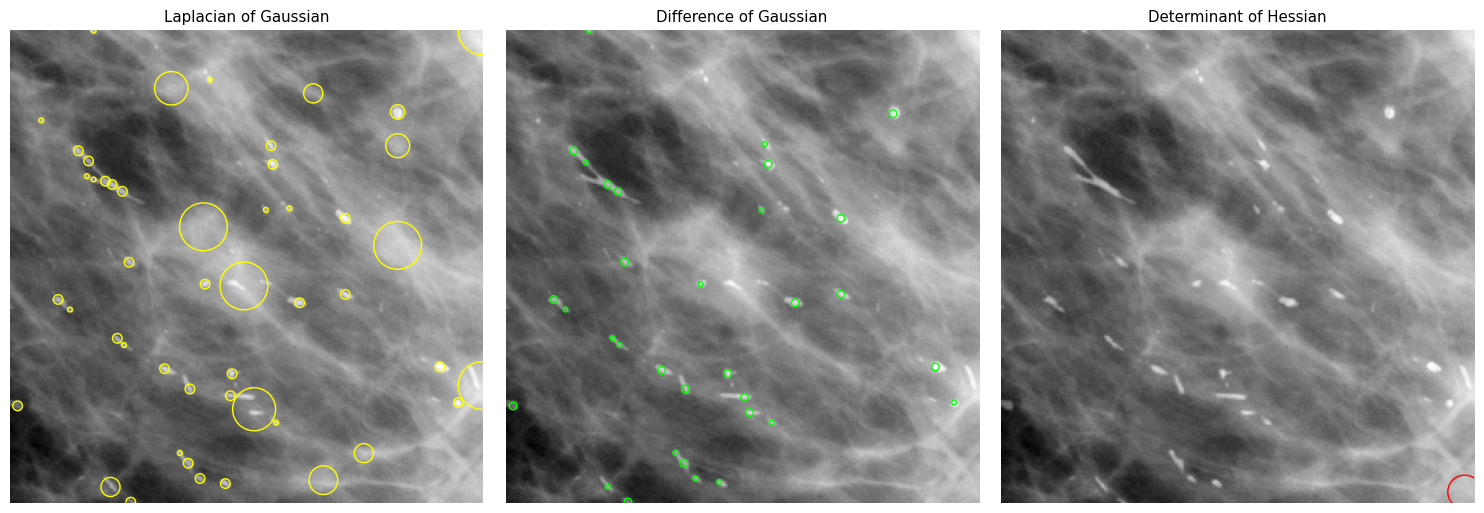

Parametros: max_sigma. FILTRO BLOBS_DOG. Diference of Gaussian
20
el blob es: 0
el blob es: 1
el blob es: 2


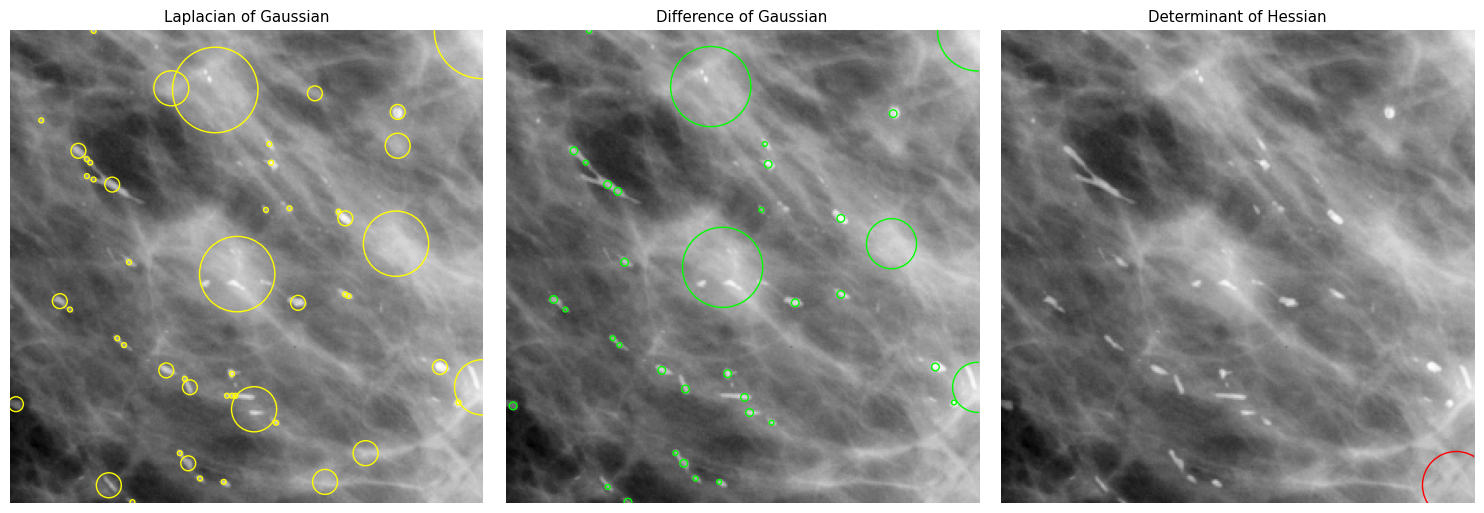

Max_sigma = 10
Blobs encontrados por blobs_dog: 33
Max_sigma = 20
Blobs encontrados por blobs_dog: 37


In [63]:

from math import sqrt
from skimage import data
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray

import matplotlib.pyplot as plt



max_sigma=[10,20]


for k in max_sigma:
    blobs_log = blob_log(imagen_recorte_norm, min_sigma=1,max_sigma=k, threshold=0.1)
    # Compute radii in the 3rd column.
    print("Parametros: max_sigma. FILTRO BLOBS_DOG. Diference of Gaussian")
    blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

    blobs_dog = blob_dog(imagen_recorte_norm, min_sigma=1,max_sigma=k,threshold=.1)
    blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)

    blobs_doh = blob_doh(imagen_recorte_norm, min_sigma=1, max_sigma=k,threshold=0.01)

    blobs_list = [blobs_log, blobs_dog, blobs_doh]
    colors = ['yellow', 'lime', 'red']
    titles = ['Laplacian of Gaussian', 'Difference of Gaussian',
              'Determinant of Hessian']
    sequence = zip(blobs_list, colors, titles)
    print(k)

    #fig,axes = plt.subplots(1,2, figsize=(15, 3), sharex=True, sharey=True)
    #ax = axes.ravel()

    fig, axes = plt.subplots( 1,3,figsize=(15, 5))
    ax = axes.ravel()

    for idx, (blobs, color, title) in enumerate(sequence):
        print("el blob es:", idx)
        axes[idx].set_title(title)
        axes[idx].imshow(imagen_recorte_norm, cmap="gray")
        for blob in blobs:
            y, x, r = blob
            #print("el radio es:", r)
            c = plt.Circle((x, y), r, color=color, linewidth=1, fill=False)
            ax[idx].add_patch(c)
        ax[idx].set_axis_off()

    #graficar_imagen(recorte_209_rgb, 'img_rgb', tamaño=60)

    plt.tight_layout()
    plt.show()

##############
for k1 in max_sigma:
   # blobs_log = blob_log(imagen_final_norm, min_sigma=1, max_sigma=k1,threshold=0.1)
    blobs_dog = blob_dog(imagen_recorte_norm, min_sigma=1, max_sigma=k1,threshold=0.1)
   # blobs_doh = blob_doh(imagen_final_norm,min_sigma=1, max_sigma=k1, threshold=0.01)

    print(f"Max_sigma = {k1}")
   # print(f"Blobs encontrados por blobs_log: {len(blobs_log)}")
    print(f"Blobs encontrados por blobs_dog: {len(blobs_dog)}")
    #print(f"Blobs encontrados por blobs_doh: {len(blobs_doh)}")

#  IMAGENES IMPORTANTES EN LA METODOLOGÍA DE SEGMENTACIÓN AUTOMÁTICA